# Encoder - MVP

> Self supervised learning Masked Value Prediction (MVP) as a way to create the embeddings.
Based on tsai's MVP

In [1]:
# This is only needed if the notebook is run in VSCode
import sys
if '--vscode' in sys.argv:
    print("Executing inside vscode")
    import nbs_pipeline.utils.vscode  as vs
    vs.DisplayHandle.update = vs.update_patch

In [2]:
import warnings
warnings.filterwarnings("ignore", module="umap")
import os
import sys
sys.path.append(os.path.abspath('..'))
from dvats.all import *
from fastcore.all import *
from tsai.basics import *
from tsai.models.InceptionTimePlus import *
from tsai.callback.MVP import *
import matplotlib.colors as colors
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from fastai.callback.schedule import *
from fastai.callback.tracker import EarlyStoppingCallback
from tsai.data.preparation import prepare_forecasting_data
from tsai.data.validation import get_long_term_forecasting_splits, get_forecasting_splits #TODO: Quitar 1 cuando esté decidida la opción

import wandb
wandb_api = wandb.Api()



## Setup CUDA

In [3]:
#cuda_device=1
cuda_device=0
device = torch.device(f'cuda:{cuda_device}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
#os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:2048'

## Get configutation from yml
> This file used the configuration files './config/base.yml' and './config/02b_encoder_MVP.ipynb'

In [4]:
import nbs_pipeline.utils.config as cfg
user, project, version, data, config, job_type = cfg.get_artifact_config_MVP_SWV(False)

Changing to online analysis mode - use_wandb=true


In [5]:
for key, value in config.items():
    print(f"{key}: {value}")

alias: toy
analysis_mode: online
batch_size: 512
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: (10, 30)
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 1
train_artifact: mi-santamaria/deepvats/toy:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 30
wandb_group: None


## Setup Weights & biases artiffact

In [6]:
path = os.path.expanduser("~/work/nbs_pipeline/")
name="02c_encoder_MVP-sliding_window_view"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
print("runname: "+runname)

runname: 02c_encoder_MVP-sliding_window_view


In [7]:
#hide
run = wandb.init(
    entity = user,
    # work-nbs is a place to log draft runs
    project=project,
    group=config.wandb_group,
    job_type=job_type,
    allow_val_change=True,
    mode=config.analysis_mode,
    config=config,
    # When use_wandb is false the run is not linked to a personal account
    #NOTE: This is not working right now
    anonymous = 'never' if config.use_wandb else 'must', resume=False,
    name = runname
)
config = run.config  # Object for storing hyperparameters
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact


wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


'stream.Stream' object attribute 'write' is read-only


## Split data using Sliding Window & Get training artiffact

### Get W&B train artifact

In [8]:
train_artifact = artifacts_gettr(config.train_artifact)

In [9]:
df_train = train_artifact.to_df()
print(df_train.shape)
df_train.head

wandb:   1 of 1 files downloaded.  


(550, 3)


<bound method NDFrame.head of                            T3        T2        T1
1970-01-01 00:00:00  0.741822  0.637180  0.565117
1970-01-01 00:00:01  0.739731  0.629415  0.493513
1970-01-01 00:00:02  0.718757  0.539220  0.469350
1970-01-01 00:00:03  0.730169  0.577670  0.444100
1970-01-01 00:00:04  0.752406  0.570180  0.373008
...                       ...       ...       ...
1970-01-01 00:09:05  0.634965  0.516560  0.780111
1970-01-01 00:09:06  0.637140  0.544686  0.802453
1970-01-01 00:09:07  0.639375  0.512788  0.853659
1970-01-01 00:09:08  0.616411  0.509230  0.817400
1970-01-01 00:09:09  0.569368  0.460593  0.839449

[550 rows x 3 columns]>

### Get training set
> Use `prepare_forecasting_data` from tsai. Must take into account it uses the following variables:
> | Variable         | Definition                                           | Default Value | Value Utilised   |
> |------------------|------------------------------------------------------|---------------|------------------|
> | `df`             | Time series DataFrame.                               | -             | `df_train`       |
> | `fcst_history`   | Input historical steps. Window size.                 | -             | `config.w`       |
> | `fcst_horizon`   | Future predicted steps.                              | `1`           | - (no forecasts) |
> | `x_vars`         | Input variables.                                     | `None`        | - (all columns)  |
> | `y_vars`         | Output variables.                                    | `None`        | -                |
> | `dtype`          | Output datatype (for example, `'float32'`).          | `None`        | -                |
> | `unique_id_cols` | None or unique identifier column id.                 | -             | -                |
> 
> For more information, visit [tsai - data - preparation - prepare_forecasting_data](https://timeseriesai.github.io/tsai/data.preparation.html#prepare_forecasting_data)recasting_data)

In [10]:
X_train, _ = prepare_forecasting_data(df_train, fcst_history = config.w)

In [11]:
print(X_train.shape)

(520, 3, 30)


### Apply strides
> Once we have build the windows, we can apply strides in order to check have the same structure as when used via sliding window

In [12]:
X_strided = X_train[::config.stride]
X = X_train

In [13]:
print("X ~ ", X.shape)
print("X_strided ~ ", X_strided.shape)

X ~  (520, 3, 30)
X_strided ~  (520, 3, 30)


### Split Training Set into Training and Test Dataset

> Use the `get_forecasting_splits` function from tsai to split your time series data. Understand and adapt the parameters to suit your needs:
>
> | Variable               | Definition                                             | Default Value | Value Utilised     |
> |------------------------|--------------------------------------------------------|---------------|--------------------|
> | `df`                   | DataFrame containing a sorted time series.             | -             | `df_train`         |
> | `fcst_history`         | Number of historical steps used as input.              | -             | `config.w`         |
> | `fcst_horizon`         | Number of steps forecasted into the future.            | `1`           | 1 (no forecasts)   |
> | `stride`               | Strides of the sliding windows (input and target).     | `1`           | `config.stride`    |
> | `valid_size`           | Size of the training set (based on datetimes).         | `0.0`         | `config.valid_size`|
> | `test_size`            | Size of the test set (based on datetimes).             | `0.2`         | `0.2`              |
> | `valid_cutoff_datetime`| First prediction datetime of validation dataset.       | `None`        | -                  |
> | `test_cutoff_datetime` | First prediction datetime of test dataset.             | `None`        | -                  |
> | `datetime_col`         | Column with the datetime values.                       | `None`        | `config.time_col   |
> | `use_index`            | Flag to indicate if datetime is in the index.          | `False`       | `True`             |
> | `unique_id_cols`       | Column/s with the unique identifier/s for each entity. | `None`        | -                  |
> | `show_plot`            | Flag to indicate if splits should be plotted.          | `True`        | `True`             |
>
> For more information, visit [tsai - Splitting data - get_forecasting_splits](https://timeseriesai.github.io/tsai/data.validation.html#get_forecasting_splits).

In [14]:
assert config.analysis_mode in ['offline','online'], 'Invalid analysis mode'

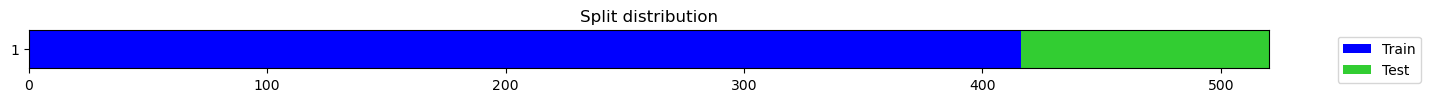

((#416) [0,1,2,3,4,5,6,7,8,9...],
 (#104) [416,417,418,419,420,421,422,423,424,425...])

In [15]:
if config.analysis_mode == 'online': 
    splits = get_forecasting_splits(
        df = df_train, 
        fcst_history = config.w,
        fcst_horizon = 1,
        stride = config.stride, 
        test_size = 0.2,
        show_plot = True
    )
    #    splits = TimeSplitter(valid_size=0.2, show_plot=True)(X)
elif config.analysis_mode == 'offline':
    splits = get_splits(np.arange(len(X_strided)), valid_size=config.valid_size)

splits


## MVP - Encoder training
> Train MVP with optional adaptable window sizes, to allow for inference with different
window sizes, to provide an easier exploration of the embedding space through different
ways of sliding the data.

### Set callback list

In [16]:
cbs = L(WandbCallback(log_preds=False)) if config.use_wandb else L()

### Set transformations

In [17]:
tfms = [ToFloat(), None]
batch_tfms = [TSStandardize(by_sample=config.norm_by_sample, 
               use_single_batch=config.norm_use_single_batch)]

### Get data loaders

(520, 3, 30)


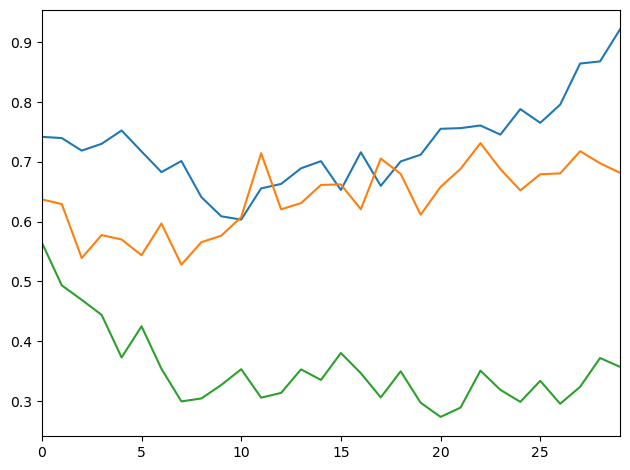

In [18]:
print(X.shape)
dls = get_ts_dls(X, splits=splits, tfms=tfms, bs=config.batch_size, batch_tfms=batch_tfms)
dls.show_at(0)

#### Check dls

In [19]:
print("X ~", X.shape) 
print("dls batch size", dls.bs)


X ~ (520, 3, 30)
dls batch size 416


### Build MVP TS Learner

In [20]:
sgc = ShowGraphCallback2()
learn = ts_learner(dls, InceptionTimePlus, 
                   cbs= cbs + sgc + MVP(
                       r = config.r, 
                        window_size=config.mvp_ws, 
                        future_mask = config.mask_future, 
                        target_dir='./models', 
                        sync = config.mask_sync, 
                        stateful = config.mask_stateful,
                        fname=f'encoder_MVP'
                    ), y_range=[X.min(), X.max()])

#### Check learner

In [21]:
print("learn dls.bs",  learn.dls.bs)

learn dls.bs 416


### Example mask

#### Create mask

In [22]:
if config.mask_future:
    example_mask = create_future_mask(torch.from_numpy(X[0]), config.r, sync=config.mask_sync)
else:
    example_mask = create_subsequence_mask(torch.from_numpy(X[0]), config.r, stateful=config.mask_stateful, sync=config.mask_sync)

#### Show mask

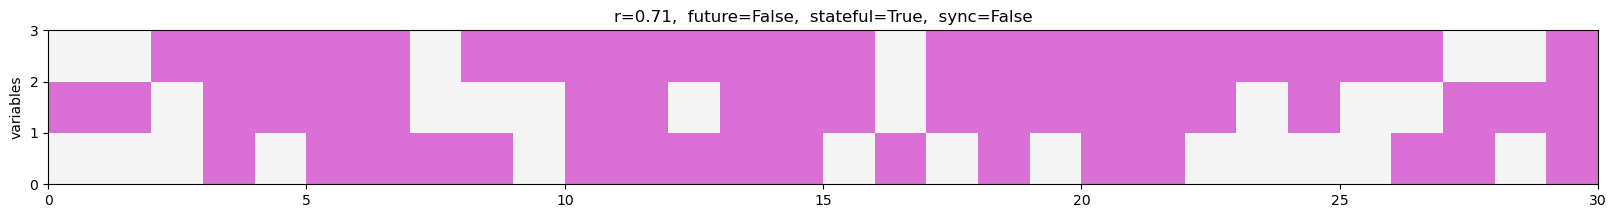

In [23]:
fig, ax = plt.subplots(figsize=(20, 2))
plt.pcolormesh(example_mask[0], cmap=colors.ListedColormap(['whitesmoke', 'orchid']))
plt.title(f'r={config.r},  future={config.mask_future},  stateful={config.mask_stateful},  sync={config.mask_sync}')
ax.set_ylabel('variables')
plt.show()

 ## Check window size configuration

### Check config attributes

In [24]:
expected_window_size = config.mvp_ws
print("w", config.w, "mvp_ws", config.mvp_ws)
print("expected ", expected_window_size)


w 30 mvp_ws [10, 30]
expected  [10, 30]


### Check obtained attributes

In [25]:
mvp_cb = learn.cbs.filter(lambda cb: isinstance(cb, MVP))[0]  # Encuentra el callback MVP
obtained_window_size=mvp_cb.window_size
print("obtained ", obtained_window_size)

obtained  [10, 30]


In [26]:
if (expected_window_size != obtained_window_size):
    raise ValueError("Obtained window_size for MVP training different from expected window size. Check size, ws1 & ws2 parameters in '02b-encoder_MVP.yaml'")
else: 
    print("Obtained window size tuple is the expected one. Continue!")

Obtained window size tuple is the expected one. Continue!


#### Check w1 < w2 for MVP random window size selection

In [27]:
if (obtained_window_size[1] < obtained_window_size[0]):
    raise ValueError("Ws2 must be greater than Ws1 as they are the maximun and minimum window size respectively. Please ensure w2 > w1")
else: 
    print(obtained_window_size[0])
    print(obtained_window_size[1])
    print(obtained_window_size)
    ws = np.random.randint(*obtained_window_size)
    print(ws)

10
30
[10, 30]
17


#### Check self.x.shape[-1] for np.random.randint(0, self.x.shape[-1] - ws) MMVP calculus

In [28]:
#Get data batch
x = next(iter(dls.train))
print("x", x)
x_data=x[0]
print("Data shape: " + str( x_data.shape))
time_serie_len = x_data.shape[-1]
print("Time serie len: " + str( time_serie_len))
#Just in case
diff = time_serie_len - ws
print("diff time serie len - ws:", diff)
result = np.random.randint(0, diff)
print("ws ", ws, "diff", diff, "result",  result)

x (TSTensor(samples:416, vars:3, len:30, device=cuda:0, dtype=torch.float32),)
Data shape: torch.Size([416, 3, 30])
Time serie len: 30
diff time serie len - ws: 13
ws  17 diff 13 result 9


### Train the model

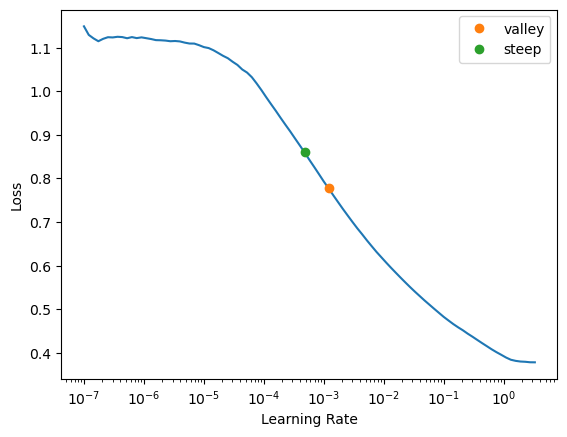

In [29]:
lr_valley, lr_steep = learn.lr_find(suggest_funcs=(valley, steep))

epoch     train_loss  valid_loss  time    
0         1.116455    1.349414    00:00     


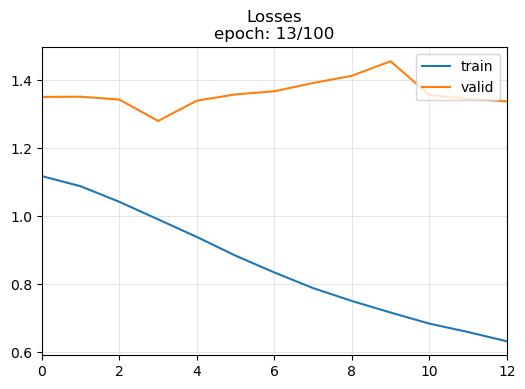

1         1.086686    1.349900    00:00     
2         1.040846    1.341603    00:00     
3         0.989263    1.278669    00:00     
4         0.937514    1.338328    00:00     
5         0.882487    1.356795    00:00     
6         0.833140    1.366018    00:00     
7         0.787160    1.390179    00:00     
8         0.749308    1.411479    00:00     
9         0.715261    1.454157    00:00     
10        0.682746    1.354999    00:00     
11        0.657918    1.343508    00:00     
12        0.630757    1.336244    00:00     
13        0.605284    1.378359    00:00     
No improvement since epoch 3: early stopping


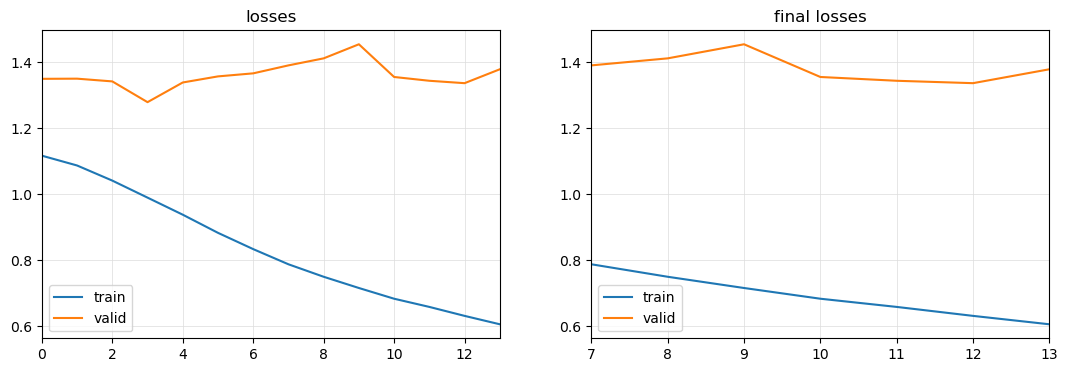

In [30]:

learn.fit_one_cycle(n_epoch=config.epochs, lr_max=lr_valley,  cbs=[EarlyStoppingCallback(monitor='valid_loss', min_delta=0.000001, patience=10)])

#### Validate the model

In [31]:
learn.validate()

not enough values to plot a chart


(#1) [1.4360244274139404]

## Visualize predictions

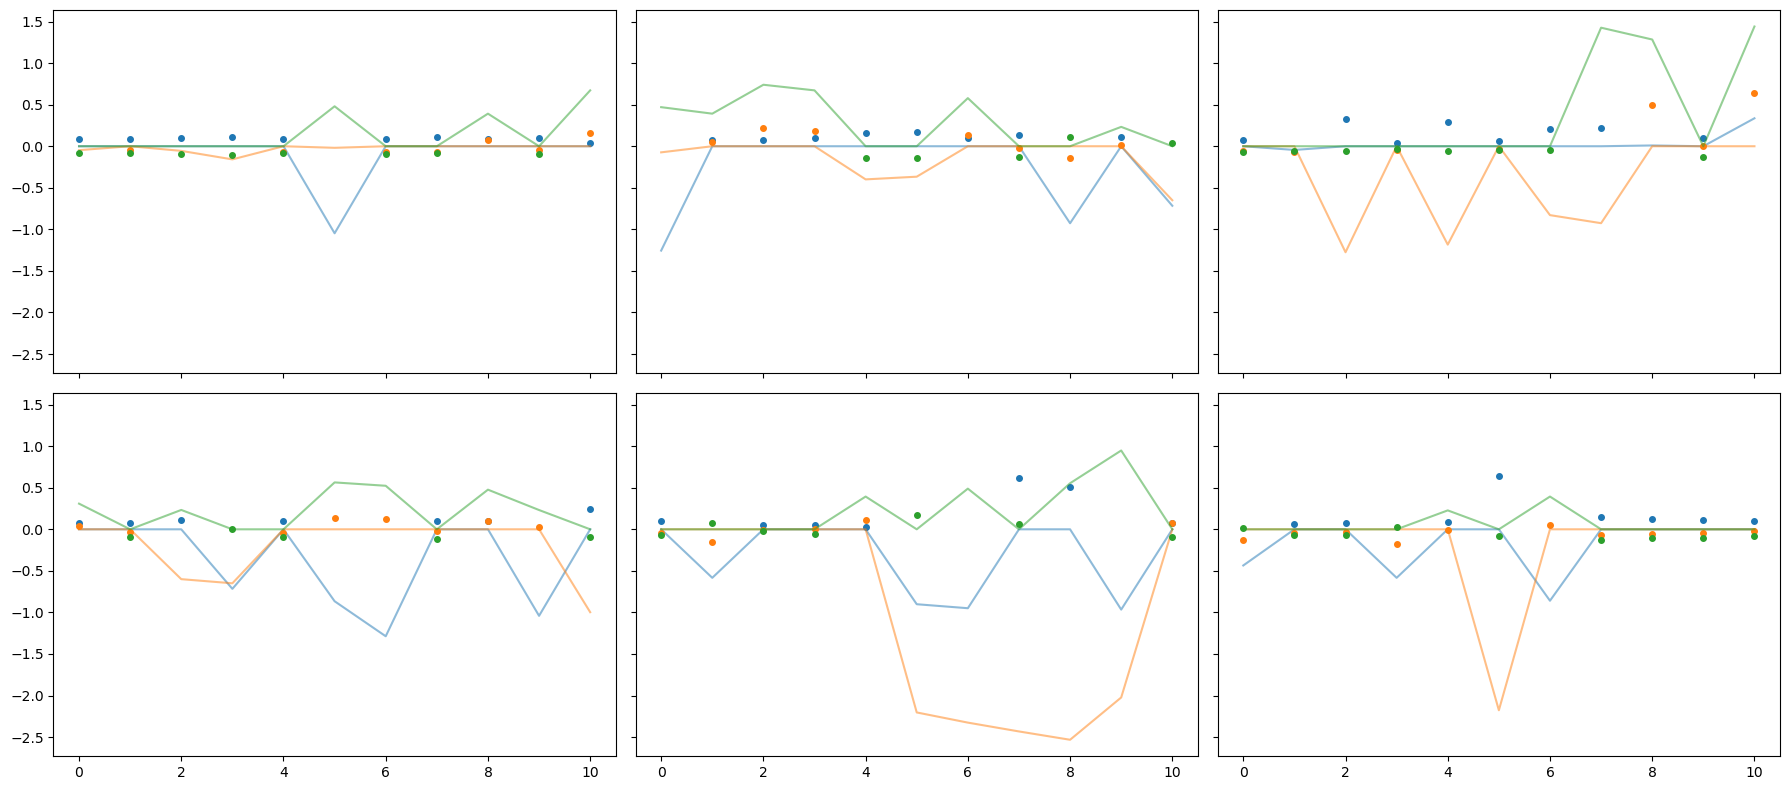

In [32]:
learn.MVP.show_preds(sharey=True, nrows=2) # error with nwors=1 or ncols=1

## Save artifact to W&B
> Remove extra information and saving the learner object as an weight and biases artifact

In [33]:
# Remove the ShowGraphCallback2 callback to avoid errors in the frontend (TODO)
learn.remove_cb(sgc)

In [34]:
# Log the learner without the datasets
aux_learn = learn.export_and_get()
if config.use_wandb: 
    run.log_artifact(
        ReferenceArtifact(
            aux_learn, 
            f'mvp-SWV', 
            type='learner', 
            metadata=dict(run.config)
        ), 
        aliases=config.alias
    )

## Close W&B

In [35]:
run.finish()

epoch,14
eps_0,1e-05
eps_1,1e-05
lr_0,0.00066
lr_1,0.00066
mom_0,0.89686
mom_1,0.89686
raw_loss,0.31698
sqr_mom_0,0.99
sqr_mom_1,0.99
train_loss,0.60528


## Checking 
> Comment: Remember we load the learner without the dataset

In [36]:
aux_learn.dls

In [37]:
aux_learn.dls.bs

1

In [38]:
learn.dls.bs

416

In [ ]:
reset_kernel=True
if reset_kernel:
    import os
    os._exit(00)